In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import tqdm

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sentencepiece

In [4]:
tokenizer = T5Tokenizer.from_pretrained("laituan245/molt5-large-smiles2caption", model_max_length=512)
model = T5ForConditionalGeneration.from_pretrained("laituan245/molt5-large-smiles2caption")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
import gc

def print_gpu_memory():
    allocated = torch.cuda.memory_allocated() / (1024**2)
    cached = torch.cuda.memory_reserved() / (1024**2)
    print(f"Allocated: {allocated:.2f} MB")
    print(f"Cached: {cached:.2f} MB")

# Before clearing the cache
print("Before clearing cache:")
print_gpu_memory()

# Clearing cache
gc.collect()
torch.cuda.empty_cache()

# After clearing the cache
print("\nAfter clearing cache:")
print_gpu_memory()

Before clearing cache:
Allocated: 0.00 MB
Cached: 0.00 MB

After clearing cache:
Allocated: 0.00 MB
Cached: 0.00 MB


## Load SMILES from SPECS

In [6]:
specs_smiles = pd.read_csv("/home/jovyan/share/data/analyses/Pousali/analysis cbcs0656/official_information_annotations_and_SMILES.xlsx - Chemical information.csv")

In [7]:
plp_data = pd.read_csv("/home/jovyan/share/data/analyses/PLP/data/24h_fixed-Table 1.csv", sep = ";")

In [8]:
specs_smiles_plp = specs_smiles.merge(plp_data, left_on= "Batch nr", right_on= "Batch_nr", how = "left")

In [9]:
specs_smiles_plp = specs_smiles_plp.dropna(subset = "%Induction").reset_index(drop = True)

In [10]:
unique_smiles = specs_smiles_plp["SMILES"].drop_duplicates().tolist()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
results = {}  # Create an empty dictionary to store results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for smile in tqdm.tqdm(unique_smiles):
    input_ids = tokenizer(smile, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        encoder_outputs = model.encoder(input_ids)
        hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_length, hidden_dim]

    #print(f"Hidden State Shape: {hidden_states.shape}")
    
    results[smile] = hidden_states.cpu().numpy()  # Convert to NumPy for easier processing
    
#print(f"Results Dictionary: {results}")

100%|██████████| 5254/5254 [02:03<00:00, 42.57it/s]


In [13]:
results_df = pd.DataFrame(list(results.items()), columns=["SMILES", "hidden_state_embed"])

In [14]:
import torch
import torch.nn.functional as F

def attention_weighted_pooling(hidden_states):
    """
    Applies attention-based pooling over sequence token embeddings.
    
    Args:
        hidden_states (torch.Tensor): Shape (1, seq_len, embedding_dim) = (1, 73, 1024)
    
    Returns:
        torch.Tensor: Shape (1, embedding_dim) = (1, 1024) - Pooled embedding
    """
    seq_len = hidden_states.shape[1]
    hidden_states_tensor = torch.tensor(hidden_states)  
    # Compute attention scores per token
    attention_scores = F.softmax(hidden_states_tensor.mean(dim=-1), dim=-1)  # Shape: (1, 73)
    
    # Apply attention scores to embeddings
    weighted_embeddings = torch.einsum("bs,bse->be", attention_scores, hidden_states_tensor)  # Shape: (1, 1024)
    
    return weighted_embeddings


pooled_embedding = attention_weighted_pooling(results['[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C@@H](O2)N1C(Br)=NC2=C1NC(N)=NC2=O'])
print(f"Attention Pooled Embedding Shape: {pooled_embedding.shape}")  # (1, 1024)



Attention Pooled Embedding Shape: torch.Size([1, 1024])


In [15]:
mean_pooled_results = {} 
attention_pooled_results = {} 

for smile, hidden_states in results.items():
    hidden_states_tensor = torch.tensor(hidden_states)  
    attention_weighted_emb = attention_weighted_pooling(hidden_states)
    mean_pooled_embedding = hidden_states_tensor.mean(dim=1) 
    
    mean_pooled_results[smile] = mean_pooled_embedding.squeeze(0).numpy()  
    attention_pooled_results[smile] = attention_weighted_emb.squeeze(0).numpy()  

print(f"Mean Pooled Embeddings Shape: {list(mean_pooled_results.values())[0].shape}") 

Mean Pooled Embeddings Shape: (1024,)


In [16]:
smiles = list(attention_pooled_results.keys())
embeddings = np.array(list(attention_pooled_results.values()))
feature_df = pd.DataFrame(embeddings, index=smiles)

# Reset the index and make 'smiles' a column
feature_df.reset_index(inplace=True)
feature_df.rename(columns={'index': 'SMILES'}, inplace=True)

# Rename the feature columns
feature_df.columns = ['SMILES'] + [f"Feature {i+1}" for i in range(feature_df.shape[1] - 1)]

# Display the resulting DataFrame
feature_df.head()

,SMILES,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 1015,Feature 1016,Feature 1017,Feature 1018,Feature 1019,Feature 1020,Feature 1021,Feature 1022,Feature 1023,Feature 1024
0,CC1=NN=C2N1C(SC(C)=C3C)=C3C(C4=CC=C(Cl)C=C4)=N...,0.026282,0.003927,-0.007298,-0.009500,-0.010540,-0.000705,-0.030283,-0.020155,0.007320,...,-0.005739,0.012661,-0.015097,0.010702,-0.011157,0.012608,-0.006349,-0.015423,-0.021457,-0.009879
1,[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C...,0.018997,0.007151,0.000406,-0.025929,0.010346,-0.000729,-0.017451,-0.029156,0.002748,...,0.009934,0.006220,-0.022696,-0.000621,-0.009320,0.018326,0.023429,-0.009587,-0.001043,-0.001064
2,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,0.000187,-0.020703,-0.000492,-0.036183,0.002853,-0.009577,-0.013611,0.000199,0.007635,...,0.010237,0.007523,0.009654,0.010678,-0.007181,0.003255,0.021986,0.000359,0.003666,-0.009034
3,O=C(N1)SC(CC2=CC=C(OCC(N3C)=NC4=C(C=CC=C4)C3=O...,0.030031,0.015349,-0.008001,-0.000282,-0.006163,0.003419,-0.028520,-0.029539,0.008948,...,-0.016164,0.003672,-0.018186,-0.015660,0.008122,0.013242,-0.006255,-0.011425,-0.020378,-0.004116
4,Fc1ccc(cc1)C(c2ccccc2)(c3ccccc3F)n4ccnc4,0.000084,0.017451,0.013805,-0.006222,0.003634,0.023569,-0.023125,-0.027876,-0.002959,...,-0.011726,0.013825,-0.028647,-0.016706,-0.009649,0.011110,0.013942,-0.006245,-0.012802,-0.002457


In [17]:
feature_df = pd.merge(feature_df, specs_smiles_plp, on='SMILES', how='left')

In [19]:
feature_df.to_csv("molt5_specs5k_features.csv")

In [20]:
high_cols = [col for col in specs_smiles_plp.columns if "High" in col or "nontoxic" in col]
nont_tox_cols = [col for col in specs_smiles_plp.columns if "nontoxic" in col]
low_cols = [col for col in specs_smiles_plp.columns if "Low" in col]

# Create the label column based on conditions
feature_df["label"] = "no_plp"  # Default
feature_df["label_refined"] = "no_plp" # Default


# If any High columns are 1, set label to 1
feature_df.loc[feature_df[high_cols].sum(axis=1) > 0, "label"] = "high_tox_plp"

feature_df.loc[feature_df[["High_PLP_10uM_>80"]].sum(axis=1) > 0, "label_refined"] = "high_tox_plp"
feature_df.loc[feature_df[["nontoxic_10uM_>80"]].sum(axis=1) > 0, "label_refined"] = "non_tox_plp"

# If any Low columns are 1, set label to 1
feature_df.loc[feature_df[low_cols].sum(axis=1) > 0, "label"] = "low_plp"

feature_df.loc[feature_df[low_cols].sum(axis=1) > 0, "label_refined"] = "low_plp"

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
feature_df['label'] = le.fit_transform(feature_df['label'])
moa_mapping = list(zip(le.classes_, range(len(le.classes_))))
print("PLP Mapping:", moa_mapping)

PLP Mapping: [('high_tox_plp', 0), ('low_plp', 1), ('no_plp', 2)]


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


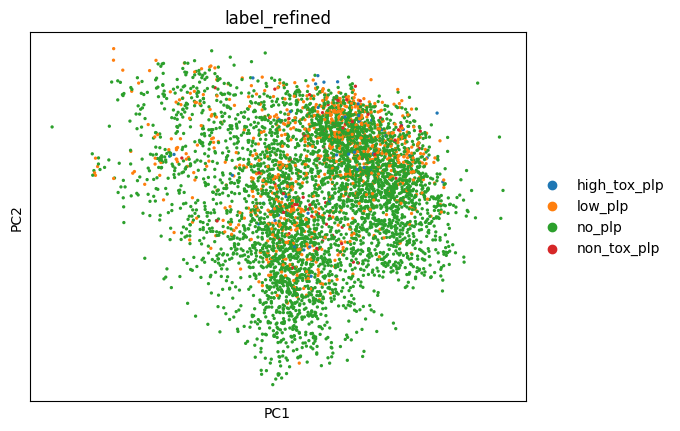

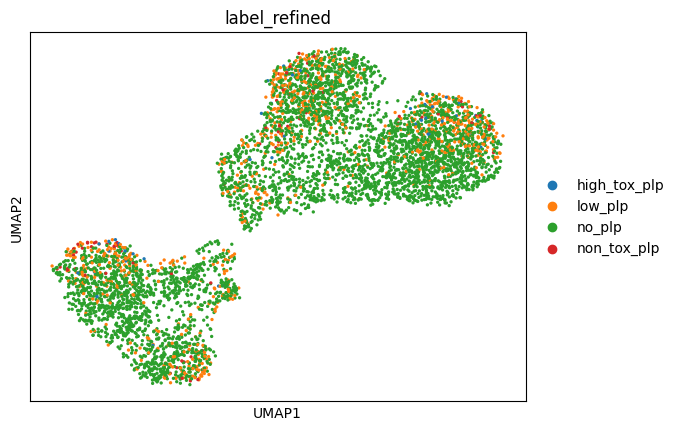

In [22]:
features = [feat for feat in feature_df.columns if "Feature" in feat]
meta_feats = [feat for feat in feature_df.columns if feat not in features]
adata = ad.AnnData(X = feature_df[features],obs=feature_df[meta_feats])

sc.tl.pca(adata, n_comps=150)
sc.pl.pca(adata, color='label_refined',legend_loc="right margin")
sc.pp.neighbors(adata, n_neighbors=100)
sc.tl.umap(adata)
sc.pl.umap(adata, color='label_refined',legend_loc="right margin")

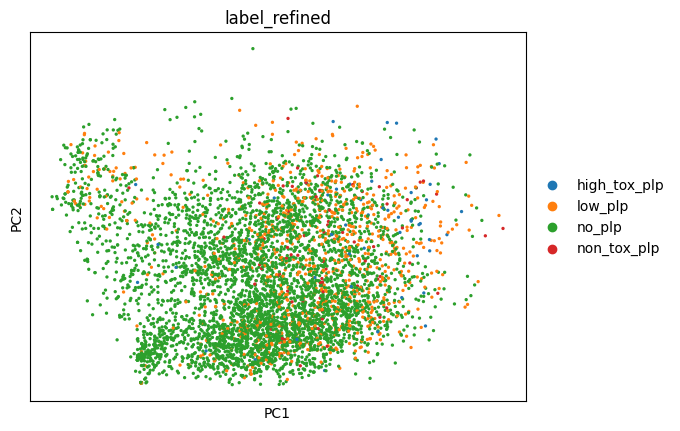

/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


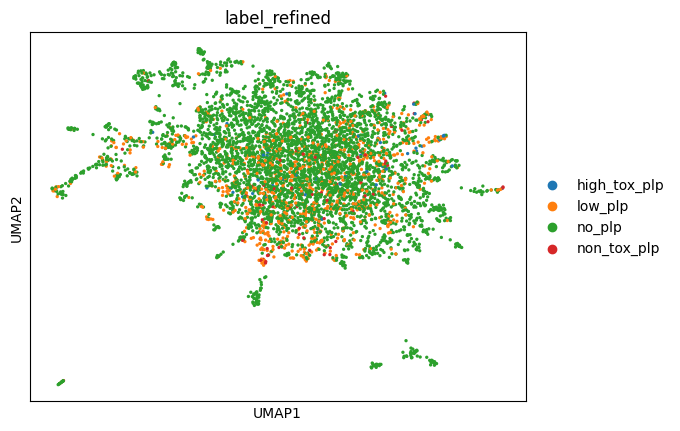

In [26]:
sc.tl.pca(adata_morgan, n_comps=150)
sc.pl.pca(adata_morgan, color='label_refined',legend_loc="right margin")
sc.pp.neighbors(adata_morgan)
sc.tl.umap(adata_morgan)
sc.pl.umap(adata_morgan, color='label_refined',legend_loc="right margin")

KeyError: 'Could not find key LogP in .var_names or .obs.columns.'

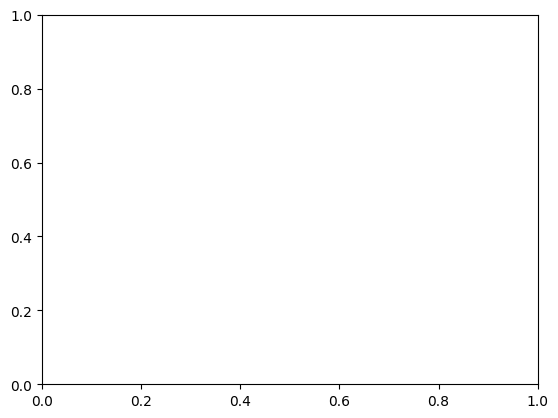

In [23]:
#sc.pl.umap(adata, color='%Induction',legend_loc="right margin")
sc.pl.umap(adata, color='LogP',legend_loc="right margin", vmin = -15)
sc.pl.umap(adata, color='MOLWEIGHT',legend_loc="right margin", vmax=1000)
sc.pl.umap(adata, color='TPSA',legend_loc="right margin", vmax=500)
sc.pl.umap(adata, color='louvain',legend_loc="right margin")

In [31]:
adata

AnnData object with n_obs × n_vars = 5255 × 1024
    obs: 'SMILES', 'Compound ID', 'Batch nr', 'CUSTOMER_ID', 'MOLFORMULA', 'MOLWEIGHT', 'NAME', 'VENDOR', 'ADD_INFO', 'IUPAC_NAME', 'STEREOCHEMISTRY', 'pert_iname', 'clinical_phase', 'moa', 'target', 'disease_area', 'indication', 'Plate', 'Well', 'Compound_ID', 'Batch_nr', 'Concentration uM', '%Induction', 'Cell_to_DMSO', 'High_PLP_10uM_>80', 'No_PLP_10uM_<4.53', 'Low_PLP_10uM_between', 'nontoxic_10uM_>80', 'confirmed_in_fix', 'label', 'label_refined', 'louvain'
    uns: 'pca', 'label_refined_colors', 'neighbors', 'umap', 'louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

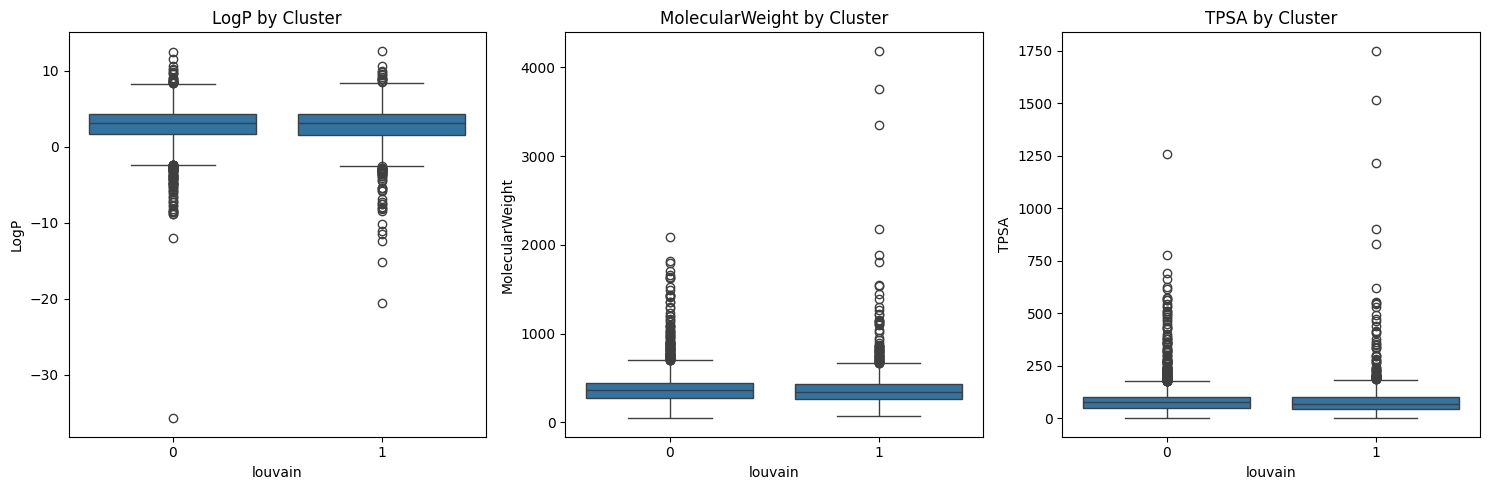

In [35]:
# Assuming clusters are labeled, e.g., adata.obs["cluster"]
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, prop in zip(axes, ["LogP", "MolecularWeight", "TPSA"]):
    sns.boxplot(data=adata.obs, x="louvain", y=prop, ax=ax)
    ax.set_title(f"{prop} by Cluster")

plt.tight_layout()
plt.show()

## RDKIT for chemical properties

In [32]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

In [28]:
def compute_molecular_properties(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")

        properties = {
            "MolecularWeight": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),  # Octanol-water partition coefficient
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "TPSA": Descriptors.TPSA(mol),  # Topological polar surface area
        }
    except Exception as e:
        print(f"Error processing SMILES: {smiles} - {e}")
        properties = {
            "MolecularWeight": np.nan,
            "LogP": np.nan,
            "NumHAcceptors": np.nan,
            "NumHDonors": np.nan,
            "NumRotatableBonds": np.nan,
            "TPSA": np.nan,
        }
    
    return properties

In [25]:
adata.obs["SMILES"] = adata.obs["SMILES"].astype(str)
properties_list = adata.obs["SMILES"].apply(compute_molecular_properties)

# Convert list of dictionaries to DataFrame
properties_df = pd.DataFrame(properties_list.tolist(), index=adata.obs.index)

# Fill NaNs if any molecules failed
properties_df = properties_df.fillna(np.nan)

# Merge into adata.obs
adata.obs = pd.concat([adata.obs, properties_df], axis=1)

# Save updated AnnData
adata.write_h5ad("your_updated_file.h5ad")

print("Added molecular properties to AnnData object!")


[10:46:07] SMILES Parse Error: syntax error while parsing: O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H](
[10:46:07] SMILES Parse Error: check for mistakes around position 200:
[10:46:07] )[C@H](O)C)=O)C[C@H](
[10:46:07] ~~~~~~~~~~~~~~~~~~~~^
[10:46:07] SMILES Parse Error: Failed parsing SMILES 'O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H](' for input: 'O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H]('
[10:46:07] Explicit valence for atom # 45 O, 3, is greater than permitted
[10:46:08] non-ring atom 41 marked aromatic


Error processing SMILES: O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H]( O)C2)=O)C4=O)=CC=C1O)([O-])=O - Invalid SMILES
Error processing SMILES: O=C(CC(N)CCCN)NCC(C(N/C(C(NC(C1NC(NCC1)=N)C2=O)=O)=C/NC(N)=O)=O)NC(C(NC(C(CN2)N)=O)C)=OO - Invalid SMILES
Error processing SMILES: CC1=C(CCC(CCCC(C)CCCC(C)CCCC(C)C)(C)O2)C2=C(C)C(C)=C1OC(CCC(OCCO)=O)=O.[n] - Invalid SMILES


[10:46:08] SMILES Parse Error: syntax error while parsing: O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(N[C@@H](C(C)C)C(N5[C@](CCC5)([H])C(N(C)CC(N(C)[C@@H](C(C)C)C(O[C@@H]4C)=O)=O)=O)=O)=O)=O)=CC=C3C)=O)N[C@@H]6C(N[C@@H](C(C)C)C(N7[C@](CCC7)([H])C(N(C)CC(N(
[10:46:08] SMILES Parse Error: check for mistakes around position 200:
[10:46:08] CCC7)([H])C(N(C)CC(N(
[10:46:08] ~~~~~~~~~~~~~~~~~~~~^
[10:46:08] SMILES Parse Error: Failed parsing SMILES 'O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(N[C@@H](C(C)C)C(N5[C@](CCC5)([H])C(N(C)CC(N(C)[C@@H](C(C)C)C(O[C@@H]4C)=O)=O)=O)=O)=O)=O)=CC=C3C)=O)N[C@@H]6C(N[C@@H](C(C)C)C(N7[C@](CCC7)([H])C(N(C)CC(N(' for input: 'O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(N[C@@H](C(C)C)C(N5[C@](CCC5)([H])C(N(C)CC(N(C)[C@@H](C(C)C)C(O[C@@H]4C)=O)=O)=O)=O)=O)=O)=CC=C3C)=O)N[C@@H]6C(N[C@@H](C(C)C)C(N7[C@](CCC7)([H])C(N(C)CC(N('
[10:46:08] SMILES Parse Error: syntax error while parsing: C[C@]([C@@](C[C@H]1O)([H])[C@]2(CC[C@@H]3O[C@@](O[C@H](CO)[C@@H](O)[C@@H]4

Error processing SMILES: O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(N[C@@H](C(C)C)C(N5[C@](CCC5)([H])C(N(C)CC(N(C)[C@@H](C(C)C)C(O[C@@H]4C)=O)=O)=O)=O)=O)=O)=CC=C3C)=O)N[C@@H]6C(N[C@@H](C(C)C)C(N7[C@](CCC7)([H])C(N(C)CC(N( C)[C@@H](C(C)C)C(O[C@@H]6C)=O)=O)=O)=O)=O - Invalid SMILES
Error processing SMILES: C[C@]([C@@](C[C@H]1O)([H])[C@]2(CC[C@@H]3O[C@@](O[C@H](CO)[C@@H](O)[C@@H]4O)([H])[C@@H]4O[C@]([C@@H]([C@@H](O)[C@@H]5O)O)([H])O[C@@H]5CO)C)(CC[C@@]2([H])C3(C)C)[C@]6([C@@]1([H])[C@]([C@@](C)(O)CC/C=C( C)/C)([H])CC6)C - Invalid SMILES
Error processing SMILES: CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@@H](C\C=C(C)\[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)\C=C\C=C3/CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]3 4O)O2 - Invalid SMILES
Error processing SMILES: C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](OC(C)=O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)C(CCC3C2C[C@@H](O

[10:46:08] SMILES Parse Error: syntax error while parsing: ClC1=C(C=CC=C1)N2C(/C=C/C3=NN=C(C4=CC=C(C#N)C=C4)O3)=NN=C2C5=CC=C(S(C)(=O)=O)C=N5.[(E)]
[10:46:08] SMILES Parse Error: check for mistakes around position 84:
[10:46:08] =C(S(C)(=O)=O)C=N5.[(E)]
[10:46:08] ~~~~~~~~~~~~~~~~~~~~^
[10:46:08] SMILES Parse Error: Failed parsing SMILES 'ClC1=C(C=CC=C1)N2C(/C=C/C3=NN=C(C4=CC=C(C#N)C=C4)O3)=NN=C2C5=CC=C(S(C)(=O)=O)C=N5.[(E)]' for input: 'ClC1=C(C=CC=C1)N2C(/C=C/C3=NN=C(C4=CC=C(C#N)C=C4)O3)=NN=C2C5=CC=C(S(C)(=O)=O)C=N5.[(E)]'
[10:46:08] SMILES Parse Error: syntax error while parsing: O=C([C@H](C(C)C)N(C)C([C@H](CC(C)C)N(C)C([C@H](CC(C)C)N(C)C([C@@H](C)NC([C@H](C)NC([C@H](CC(C)C)N(C)C([C@H](C(C)C)NC([C@H](CC(C)C)N(C)C(CN(C)C([C@H](C(C)C)N1)=O)=O)=O)=O)=O)=O)=O)=O)=O)N(C)[C@@H](C([C
[10:46:08] SMILES Parse Error: check for mistakes around position 200:
[10:46:08] =O)=O)N(C)[C@@H](C([C
[10:46:08] ~~~~~~~~~~~~~~~~~~~~^
[10:46:08] SMILES Parse Error: Failed parsing SMILES 'O=C([C@H](C(C)C)N(C

Error processing SMILES: ClC1=C(C=CC=C1)N2C(/C=C/C3=NN=C(C4=CC=C(C#N)C=C4)O3)=NN=C2C5=CC=C(S(C)(=O)=O)C=N5.[(E)] - Invalid SMILES
Error processing SMILES: O=C([C@H](C(C)C)N(C)C([C@H](CC(C)C)N(C)C([C@H](CC(C)C)N(C)C([C@@H](C)NC([C@H](C)NC([C@H](CC(C)C)N(C)C([C@H](C(C)C)NC([C@H](CC(C)C)N(C)C(CN(C)C([C@H](C(C)C)N1)=O)=O)=O)=O)=O)=O)=O)=O)=O)N(C)[C@@H](C([C @H](C)C/C=C/C)=O)C1=O - Invalid SMILES


[10:46:09] SMILES Parse Error: syntax error while parsing: CC(O)=O.O=C(N[C@@H](CO)C(N[C@H](C(N[C@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@@H](CCCNC(N)=N)C(N(CCC1)[C@@H]1C(NCC)=O)=O)=O)=O)=O)CC2=CC=C(O)C=C2)=O)[C@@H](NC([C@@H](NC([C@@H](N3)CCC3=O)=O)CC4=CNC=N4)=O)CC5=
[10:46:09] SMILES Parse Error: check for mistakes around position 200:
[10:46:09] =O)CC4=CNC=N4)=O)CC5=
[10:46:09] ~~~~~~~~~~~~~~~~~~~~^
[10:46:09] SMILES Parse Error: Failed parsing SMILES 'CC(O)=O.O=C(N[C@@H](CO)C(N[C@H](C(N[C@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@@H](CCCNC(N)=N)C(N(CCC1)[C@@H]1C(NCC)=O)=O)=O)=O)=O)CC2=CC=C(O)C=C2)=O)[C@@H](NC([C@@H](NC([C@@H](N3)CCC3=O)=O)CC4=CNC=N4)=O)CC5=' for input: 'CC(O)=O.O=C(N[C@@H](CO)C(N[C@H](C(N[C@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@@H](CCCNC(N)=N)C(N(CCC1)[C@@H]1C(NCC)=O)=O)=O)=O)=O)CC2=CC=C(O)C=C2)=O)[C@@H](NC([C@@H](NC([C@@H](N3)CCC3=O)=O)CC4=CNC=N4)=O)CC5='
[10:46:09] SMILES Parse Error: extra open parentheses while parsing: C[C@H]([C@@H](O)[C@@H](C)[C@H](C)OC1=O)/C=C/C=C/C=C/C=C/C=C/C=C/

Error processing SMILES: CC(O)=O.O=C(N[C@@H](CO)C(N[C@H](C(N[C@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@@H](CCCNC(N)=N)C(N(CCC1)[C@@H]1C(NCC)=O)=O)=O)=O)=O)CC2=CC=C(O)C=C2)=O)[C@@H](NC([C@@H](NC([C@@H](N3)CCC3=O)=O)CC4=CNC=N4)=O)CC5= CNC6=C5C=CC=C6 - Invalid SMILES
Error processing SMILES: C[C@H]([C@@H](O)[C@@H](C)[C@H](C)OC1=O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](O[C@]2([H])O[C@H](C)[C@@H](O)[C@H](N)[C@@H]2O)C[C@@]3([H])[C@H](C(O)=O)[C@@H](O)C[C@](C[C@@H](O)C[C@@H](O)[C@H](O)CC[C@@H](O)C [C@@H](O)C1)(O)O3 - Invalid SMILES
Error processing SMILES: COC1=CC=C(CC[C@@H](OC([C@@H]2CCCCN2C([C@@H](CC)C3=CC(OC)=C(OC)C(OC)=C3)=O)=O)C4=CC=CC(OCC(NCCNC(COC5=CC([C@@H](CCC6=CC=C(OC)C(OC)=C6)OC([C@@H]7CCCCN7C([C@H](C8=CC(OC)=C(OC)C(OC)=C8)CC)=O)=O)=CC=C5)=O) =O)=C4)C=C1OC - Invalid SMILES


[10:46:09] SMILES Parse Error: extra open parentheses while parsing: C[C@@H]1[C@@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](CC[C@]5(C)[C@@H]4CC[C@]23C)O[C@@H]2O[C@@H](CO)[C@@H](O[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@@H]3O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2
[10:46:09] SMILES Parse Error: check for mistakes around position 21:
[10:46:09] C[C@@H]1[C@@H]2[C@H](C[C@H]3[C@@H]4CC=C5C
[10:46:09] ~~~~~~~~~~~~~~~~~~~~^
[10:46:09] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]1[C@@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](CC[C@]5(C)[C@@H]4CC[C@]23C)O[C@@H]2O[C@@H](CO)[C@@H](O[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@@H]3O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2' for input: 'C[C@@H]1[C@@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](CC[C@]5(C)[C@@H]4CC[C@]23C)O[C@@H]2O[C@@H](CO)[C@@H](O[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@@H]3O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2'
[10:46:09] Explicit valence for atom # 0 Cl, 1, is greater than permitted


Error processing SMILES: C[C@@H]1[C@@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](CC[C@]5(C)[C@@H]4CC[C@]23C)O[C@@H]2O[C@@H](CO)[C@@H](O[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@@H]3O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2 O)O[C@]11CC[C@@H](C)CO1 - Invalid SMILES
Error processing SMILES: [Cl-][Pt+4]([O-]C(C)=O)([O-]C(C)=O)([Cl-])([NH3])[NH2]C1CCCCC1 - Invalid SMILES


[10:46:09] SMILES Parse Error: syntax error while parsing: CC[C@@H](C)C[C@@H](C)CCCCCCCCC(=O)N[C@H]1C[C@@H](O)[C@@H](NCCN)NC(=O)[C@@H]2[C@@H](O)CCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC1=O)[C@@H](C)O)[C@H](O)[C@@H](O)c1ccc(O)cc1)[C
[10:46:09] SMILES Parse Error: check for mistakes around position 200:
[10:46:09] @@H](O)c1ccc(O)cc1)[C
[10:46:09] ~~~~~~~~~~~~~~~~~~~~^
[10:46:09] SMILES Parse Error: Failed parsing SMILES 'CC[C@@H](C)C[C@@H](C)CCCCCCCCC(=O)N[C@H]1C[C@@H](O)[C@@H](NCCN)NC(=O)[C@@H]2[C@@H](O)CCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC1=O)[C@@H](C)O)[C@H](O)[C@@H](O)c1ccc(O)cc1)[C' for input: 'CC[C@@H](C)C[C@@H](C)CCCCCCCCC(=O)N[C@H]1C[C@@H](O)[C@@H](NCCN)NC(=O)[C@@H]2[C@@H](O)CCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC1=O)[C@@H](C)O)[C@H](O)[C@@H](O)c1ccc(O)cc1)[C'


Error processing SMILES: CC[C@@H](C)C[C@@H](C)CCCCCCCCC(=O)N[C@H]1C[C@@H](O)[C@@H](NCCN)NC(=O)[C@@H]2[C@@H](O)CCN2C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC1=O)[C@@H](C)O)[C@H](O)[C@@H](O)c1ccc(O)cc1)[C @H](O)CCN - Invalid SMILES


[10:46:10] SMILES Parse Error: syntax error while parsing: NCCCC[C@@H](C(N[C@H]1CC2=CC=C(C=C2)OCC3=CC=CC=C3)=O)NC([C@H](NC([C@H](C4=CC=CC=C4)NC([C@H]5N(C([C@H](CC6=CC=CC=C6)NC1=O)=O)C[C@H](OC(NCCN)=O)C5)=O)=O)CC7=CNC8=C7C=CC=C8)=
[10:46:10] SMILES Parse Error: check for mistakes around position 170:
[10:46:10] )CC7=CNC8=C7C=CC=C8)=
[10:46:10] ~~~~~~~~~~~~~~~~~~~~^
[10:46:10] SMILES Parse Error: Failed parsing SMILES 'NCCCC[C@@H](C(N[C@H]1CC2=CC=C(C=C2)OCC3=CC=CC=C3)=O)NC([C@H](NC([C@H](C4=CC=CC=C4)NC([C@H]5N(C([C@H](CC6=CC=CC=C6)NC1=O)=O)C[C@H](OC(NCCN)=O)C5)=O)=O)CC7=CNC8=C7C=CC=C8)=' for input: 'NCCCC[C@@H](C(N[C@H]1CC2=CC=C(C=C2)OCC3=CC=CC=C3)=O)NC([C@H](NC([C@H](C4=CC=CC=C4)NC([C@H]5N(C([C@H](CC6=CC=CC=C6)NC1=O)=O)C[C@H](OC(NCCN)=O)C5)=O)=O)CC7=CNC8=C7C=CC=C8)='


Error processing SMILES: NCCCC[C@@H](C(N[C@H]1CC2=CC=C(C=C2)OCC3=CC=CC=C3)=O)NC([C@H](NC([C@H](C4=CC=CC=C4)NC([C@H]5N(C([C@H](CC6=CC=CC=C6)NC1=O)=O)C[C@H](OC(NCCN)=O)C5)=O)=O)CC7=CNC8=C7C=CC=C8)= O - Invalid SMILES


[10:46:10] SMILES Parse Error: syntax error while parsing: CC[C@@]1(C=CCN2CC3)[C@@]2([H])[C@@]3(C(C=C([C@@](C4=C5C(C=CC=C6)=C6N4)(CC(C=C(CC)C7)([H])CN7C5)C(OC)=O)C(OC)=C8)=C8N9C)[C@]9([H])[C@](C(OC)=O)(O)[C@@H]1OC(C)=O.O=C(O)[C@H](O)[C@@H](O)C(O)=O.O=C(O)[C@H
[10:46:10] SMILES Parse Error: check for mistakes around position 200:
[10:46:10] ](O)C(O)=O.O=C(O)[C@H
[10:46:10] ~~~~~~~~~~~~~~~~~~~~^
[10:46:10] SMILES Parse Error: Failed parsing SMILES 'CC[C@@]1(C=CCN2CC3)[C@@]2([H])[C@@]3(C(C=C([C@@](C4=C5C(C=CC=C6)=C6N4)(CC(C=C(CC)C7)([H])CN7C5)C(OC)=O)C(OC)=C8)=C8N9C)[C@]9([H])[C@](C(OC)=O)(O)[C@@H]1OC(C)=O.O=C(O)[C@H](O)[C@@H](O)C(O)=O.O=C(O)[C@H' for input: 'CC[C@@]1(C=CCN2CC3)[C@@]2([H])[C@@]3(C(C=C([C@@](C4=C5C(C=CC=C6)=C6N4)(CC(C=C(CC)C7)([H])CN7C5)C(OC)=O)C(OC)=C8)=C8N9C)[C@]9([H])[C@](C(OC)=O)(O)[C@@H]1OC(C)=O.O=C(O)[C@H](O)[C@@H](O)C(O)=O.O=C(O)[C@H'
[10:46:10] SMILES Parse Error: unclosed ring for input: 'CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(C)c3oc4c(C)c(=O)c(N)c(C(=O)N[C@H]5[C@@H]

Error processing SMILES: CC[C@@]1(C=CCN2CC3)[C@@]2([H])[C@@]3(C(C=C([C@@](C4=C5C(C=CC=C6)=C6N4)(CC(C=C(CC)C7)([H])CN7C5)C(OC)=O)C(OC)=C8)=C8N9C)[C@]9([H])[C@](C(OC)=O)(O)[C@@H]1OC(C)=O.O=C(O)[C@H](O)[C@@H](O)C(O)=O.O=C(O)[C@H ](O)[C@@H](O)C(O)=O - Invalid SMILES
Error processing SMILES: CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(C)c3oc4c(C)c(=O)c(N)c(C(=O)N[C@H]5[C@@H](C)OC(=O)[C@H](C(C)C)N(C)C(=O)CN(C)C(=O)[C@@H]6CCCN6C(=O)[C@H](NC5=O)C(C)C)c4nc23)[C@@H](C)OC(=O)[C@H](C(C)C)N(C)C(=O)CN(C)C (=O)[C@@H]2CCCN2C1=O - Invalid SMILES
Error processing SMILES: O=C(N(CCC1)[C@@H]1C(N[C@H](C)C(N)=O)=O)[C@H](CCCNC(N)=N)NC([C@H](CC(C)C)NC([C@@H](CCCNC(N)=O)NC([C@@H](NC([C@H](CO)NC([C@H](NC([C@H](NC([C@H](NC(C)=O)CC2=CC3=CC=CC=C3C=C2)=O)CC4=CC=C(Cl)C=C4)= O)CC5=CN=CC=C5)=O)=O)CC6=CC=C(O)C=C6)=O)=O)=O - Invalid SMILES


[10:46:10] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[10:46:10] SMILES Parse Error: syntax error while parsing: C[C@@H]1OC(C[C@H](O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@@](O)(O[C@H]2C[C@H](/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@@H]([C@@H](O)[C@H]1C)C)O[C@H]3[C@@H](O)[C@@H](N)[C@H](O)[C@@H](C)O3)C[C@H](O)[C@H]2C(O)=
[10:46:10] SMILES Parse Error: check for mistakes around position 200:
[10:46:10] )C[C@H](O)[C@H]2C(O)=
[10:46:10] ~~~~~~~~~~~~~~~~~~~~^
[10:46:10] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]1OC(C[C@H](O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@@](O)(O[C@H]2C[C@H](/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@@H]([C@@H](O)[C@H]1C)C)O[C@H]3[C@@H](O)[C@@H](N)[C@H](O)[C@@H](C)O3)C[C@H](O)[C@H]2C(O)=' for input: 'C[C@@H]1OC(C[C@H](O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@@](O)(O[C@H]2C[C@H](/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@@H]([C@@H](O)[C@H]1C)C)O[C@H]3[C@@H](O)[C@@H](N)[C@H](O)[C@@H](C)O3)C[C@H](O)[C@H]2C(O)='
[10:46:10] SMILES Parse Error: syntax error while parsing: 

Error processing SMILES: [Cl-][Ru+3]([N]1=CC2=CC=CC=C2N1)([Cl-])([Cl-])([N]3=CC4=CC=CC=C4N3)[Cl-] - Invalid SMILES
Error processing SMILES: C[C@@H]1OC(C[C@H](O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@@](O)(O[C@H]2C[C@H](/C=C/C=C/C=C/C=C/CC/C=C/C=C/[C@@H]([C@@H](O)[C@H]1C)C)O[C@H]3[C@@H](O)[C@@H](N)[C@H](O)[C@@H](C)O3)C[C@H](O)[C@H]2C(O)= O)=O - Invalid SMILES
Error processing SMILES: CNC([C@@H](C1=CC=CC=C1)N2CCC3=CC(OC)=C(OC)C=C3[C@@H]2CCC4=CC=C(C(F)(F)F)C=C4)=O. - Invalid SMILES


[10:46:10] SMILES Parse Error: syntax error while parsing: CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]3C[C@@](C)(O)[C@@H](O)[C@H](C)O3)[C@@H]([C@H]2O)N(C)C)[C@@H](CC=O)C[C@@H](C)C(=O)\C=C\C(C)=C\[C@@H]1CO[C@@H]1O[C@H](C)[C@@H](O)[C@@
[10:46:10] SMILES Parse Error: check for mistakes around position 200:
[10:46:10] [C@H](C)[C@@H](O)[C@@
[10:46:10] ~~~~~~~~~~~~~~~~~~~~^
[10:46:10] SMILES Parse Error: Failed parsing SMILES 'CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]3C[C@@](C)(O)[C@@H](O)[C@H](C)O3)[C@@H]([C@H]2O)N(C)C)[C@@H](CC=O)C[C@@H](C)C(=O)\C=C\C(C)=C\[C@@H]1CO[C@@H]1O[C@H](C)[C@@H](O)[C@@' for input: 'CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]3C[C@@](C)(O)[C@@H](O)[C@H](C)O3)[C@@H]([C@H]2O)N(C)C)[C@@H](CC=O)C[C@@H](C)C(=O)\C=C\C(C)=C\[C@@H]1CO[C@@H]1O[C@H](C)[C@@H](O)[C@@'


Error processing SMILES: CC[C@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]3C[C@@](C)(O)[C@@H](O)[C@H](C)O3)[C@@H]([C@H]2O)N(C)C)[C@@H](CC=O)C[C@@H](C)C(=O)\C=C\C(C)=C\[C@@H]1CO[C@@H]1O[C@H](C)[C@@H](O)[C@@ H](OC)[C@H]1OC - Invalid SMILES


[10:46:11] SMILES Parse Error: syntax error while parsing: C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[
[10:46:11] SMILES Parse Error: check for mistakes around position 200:
[10:46:11] ]2C[C@@H](O)[C@]2(C)[
[10:46:11] ~~~~~~~~~~~~~~~~~~~~^
[10:46:11] SMILES Parse Error: Failed parsing SMILES 'C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[' for input: 'C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)['


Error processing SMILES: C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[ C@H](CC[C@]32O)C2=CC(=O)OC2)C1 - Invalid SMILES
Added molecular properties to AnnData object!


In [24]:
from rdkit.Chem import AllChem

def smiles_to_morgan(smiles, radius=2, n_bits=1024):
    """Convert a SMILES string to a Morgan fingerprint (bit vector)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits, dtype=int)  # Handle invalid molecules with zero vector
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fingerprint, dtype=int)

# Example: Extract Morgan fingerprints from an AnnData object
smiles_list = adata.obs["SMILES"].tolist()  # Extract SMILES strings

# Compute Morgan fingerprints and store as a matrix
fingerprint_matrix = np.array([smiles_to_morgan(smiles) for smiles in smiles_list])

# Create a new AnnData object to store Morgan fingerprints
adata_morgan = ad.AnnData(X=fingerprint_matrix, obs=adata.obs.copy())

# Store feature names (bit positions)
adata_morgan.var_names = [f"Bit_{i}" for i in range(fingerprint_matrix.shape[1])]

# Save as H5AD file (optional)
#adata_morgan.write("morgan_fingerprints.h5ad")

# Display basic info
print(adata_morgan)

[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerator
[12:18:43] DEPRECATION WARNING: please use MorganGenerat

AnnData object with n_obs × n_vars = 5255 × 1024
    obs: 'SMILES', 'Compound ID', 'Batch nr', 'CUSTOMER_ID', 'MOLFORMULA', 'MOLWEIGHT', 'NAME', 'VENDOR', 'ADD_INFO', 'IUPAC_NAME', 'STEREOCHEMISTRY', 'pert_iname', 'clinical_phase', 'moa', 'target', 'disease_area', 'indication', 'Plate', 'Well', 'Compound_ID', 'Batch_nr', 'Concentration uM', '%Induction', 'Cell_to_DMSO', 'High_PLP_10uM_>80', 'No_PLP_10uM_<4.53', 'Low_PLP_10uM_between', 'nontoxic_10uM_>80', 'confirmed_in_fix', 'label', 'label_refined', 'louvain'


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs
import networkx as nx

# Ensure RDKit is installed: pip install rdkit-pypi pandas numpy networkx matplotlib seaborn

def compute_molecular_properties(smiles_list):
    """
    Compute basic molecular properties for a list of SMILES strings.
    Returns a DataFrame with properties.
    """
    properties = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            properties.append({
                "SMILES": smiles,
                "MolWt": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "HBD": Descriptors.NumHDonors(mol),
                "HBA": Descriptors.NumHAcceptors(mol),
                "TPSA": Descriptors.TPSA(mol),
                "Scaffold": MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
            })
    
    df = pd.DataFrame(properties)
    return df

def analyze_cluster_properties(cluster_df):
    """
    Visualize the distribution of molecular properties across clusters.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    props = ["MolWt", "LogP", "HBD", "HBA", "TPSA"]

    for i, prop in enumerate(props):
        sns.boxplot(x="louvain", y=prop, data=cluster_df, ax=axes[i // 3, i % 3])
        axes[i // 3, i % 3].set_title(f"Distribution of {prop} per Cluster")

    plt.tight_layout()
    plt.show()

def find_frequent_substructures(smiles_list, min_occurrences=5):
    """
    Identify frequently occurring substructures in a list of SMILES.
    """
    substructure_counts = {}
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            for bond in mol.GetBonds():
                sub = Chem.MolFragmentToSmiles(mol, atomsToUse=[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                substructure_counts[sub] = substructure_counts.get(sub, 0) + 1

    # Filter by minimum occurrences
    common_substructures = {k: v for k, v in substructure_counts.items() if v >= min_occurrences}
    
    return common_substructures

def compute_tanimoto_similarity(smiles_list):
    """
    Compute a Tanimoto similarity matrix for a list of valid SMILES.
    Filters out invalid SMILES and ensures matrix dimensions are correct.
    """
    valid_smiles = []
    fps = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
            fps.append(fp)
            valid_smiles.append(smiles)  # Keep only valid ones
    
    n = len(fps)
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            sim = DataStructs.FingerprintSimilarity(fps[i], fps[j])
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # Symmetric matrix

    return sim_matrix, valid_smiles  # Return both matrix and valid SMILES


def build_similarity_network(smiles_list, threshold=0.7):
    """
    Construct a similarity network based on Tanimoto scores.
    Uses only valid molecules to avoid indexing errors.
    """
    sim_matrix, valid_smiles = compute_tanimoto_similarity(smiles_list)  # Use cleaned SMILES
    G = nx.Graph()
    
    for i in range(len(valid_smiles)):
        G.add_node(valid_smiles[i])  # Use valid SMILES

    for i in range(len(valid_smiles)):
        for j in range(i + 1, len(valid_smiles)):
            if sim_matrix[i, j] > threshold:
                G.add_edge(valid_smiles[i], valid_smiles[j], weight=sim_matrix[i, j])

    return G


def visualize_similarity_network(G):
    """
    Visualize a molecular similarity network.
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Molecular Similarity Network")
    plt.show()



In [38]:
df = compute_molecular_properties(smiles_list)
cluster_df = df.merge(adata.obs[["SMILES", "label", "louvain", "moa"]], on="SMILES", how="left")


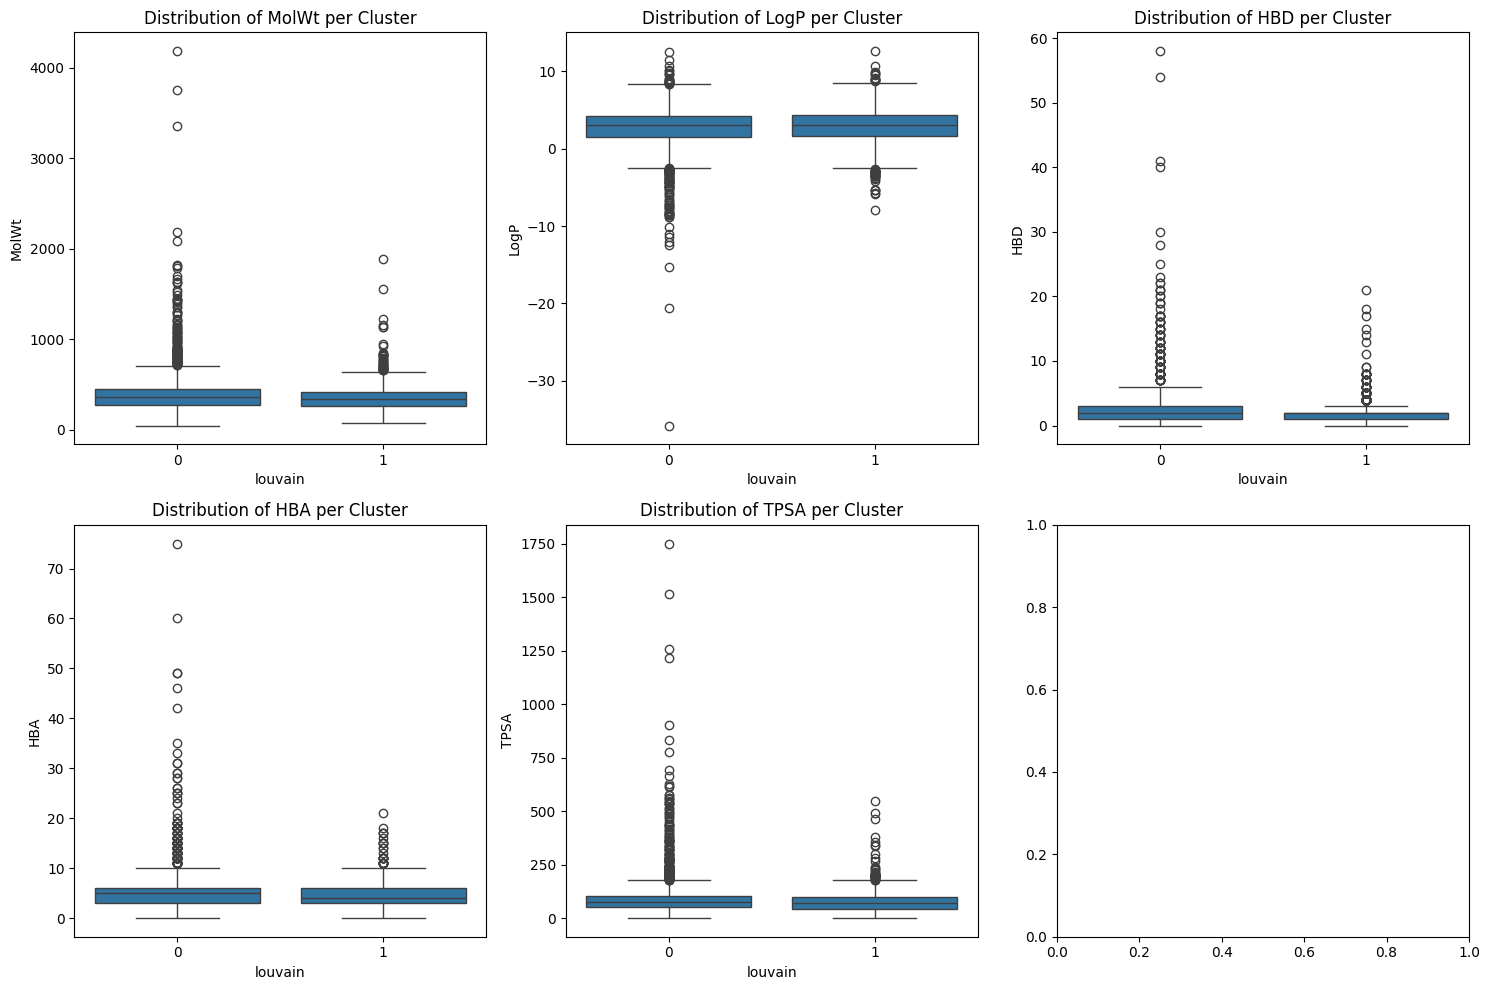

[13:57:10] SMILES Parse Error: syntax error while parsing: O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H](
[13:57:10] SMILES Parse Error: check for mistakes around position 200:
[13:57:10] )[C@H](O)C)=O)C[C@H](
[13:57:10] ~~~~~~~~~~~~~~~~~~~~^
[13:57:10] SMILES Parse Error: Failed parsing SMILES 'O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H](' for input: 'O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C@]([H])(C[C@@H](O)[C@@H](O)NC(C3N(C(C([C@H](O)CC(N)=O)N4)=O)C[C@H](C)[C@@H]3O)=O)NC(C5=CC=C(C6=NOC(C7=CC=C(OCCCCC)C=C7)=C6)C=C5)=O)=O)[C@H](O)C)=O)C[C@H]('
[13:57:11] Explicit valence for atom # 45 O, 3, is greater than permitted
[13:57:11] non-ring atom 41 marked aromatic
[13:57:11] SMIL

{'cC': 6113, 'cn': 8564, 'nn': 535, 'c-n': 190, 'cs': 687, 'cc': 47466, 'Cc': 1500, 'cCl': 1015, 'C=N': 417, 'CN': 13590, 'CC': 31727, 'cN': 2974, 'cO': 3195, 'CO': 9189, 'C=O': 5743, 'OP': 276, '[O-]P': 17, 'O=P': 120, 'Cn': 832, 'cBr': 153, 'c[nH]': 1321, 'c=O': 615, 'CS': 861, 'O=S': 1082, 'NN': 130, 'co': 556, 'c[N+]': 152, '[N+][O-]': 175, '[N+]=O': 162, 'cF': 653, 'C=C': 1317, 'cS': 615, 'C#C': 73, 'CCl': 123, 'c-c': 1069, 'C#N': 222, 'n[nH]': 109, 'CI': 3, 'CF': 1197, 'C=S': 61, 'O[Bi]': 9, 'no': 96, 'C[N+]': 405, 'NO': 127, 'C[O-]': 64, 'cI': 119, 'c=C': 5, 'C=c': 3, 'n[Cu]': 4, 'NP': 17, 'C[n+]': 32, 'c[n+]': 93, 'NS': 354, 'OS': 103, 'SS': 28, 'c[n-]': 6, 'CP': 55, 'C[PH]': 3, 'N=[N+]': 5, '[N-]=[N+]': 5, 'C[S+]': 10, 'O[Zn]': 8, 'O[Sb]': 6, 'n[Mg]': 2, 'CBr': 20, '[O-]S': 11, 'BC': 4, 'BO': 19, 'N=O': 4, 'N->[Gd+3]': 4, '[O-]->[Gd+3]': 3, '[O-]->[Sb+3]': 8, 'C=[N+]': 10, '[N+][Co]': 3, 'n[n+]': 5, '[O-]->[Mn+2]': 4, 'N->[Mn+2]': 2, 'c[O-]': 4, '[n-]->[Cu+2]': 2, 'n->[Cu+2]':

[13:57:20] SMILES Parse Error: syntax error while parsing: C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[
[13:57:20] SMILES Parse Error: check for mistakes around position 200:
[13:57:20] ]2C[C@@H](O)[C@]2(C)[
[13:57:20] ~~~~~~~~~~~~~~~~~~~~^
[13:57:20] SMILES Parse Error: Failed parsing SMILES 'C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[' for input: 'C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)['


In [44]:
analyze_cluster_properties(cluster_df)

substructures = find_frequent_substructures(smiles_list, min_occurrences=2)
print(substructures)



[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerator
[13:57:20] DEPRECATION WARNING: please use MorganGenerat

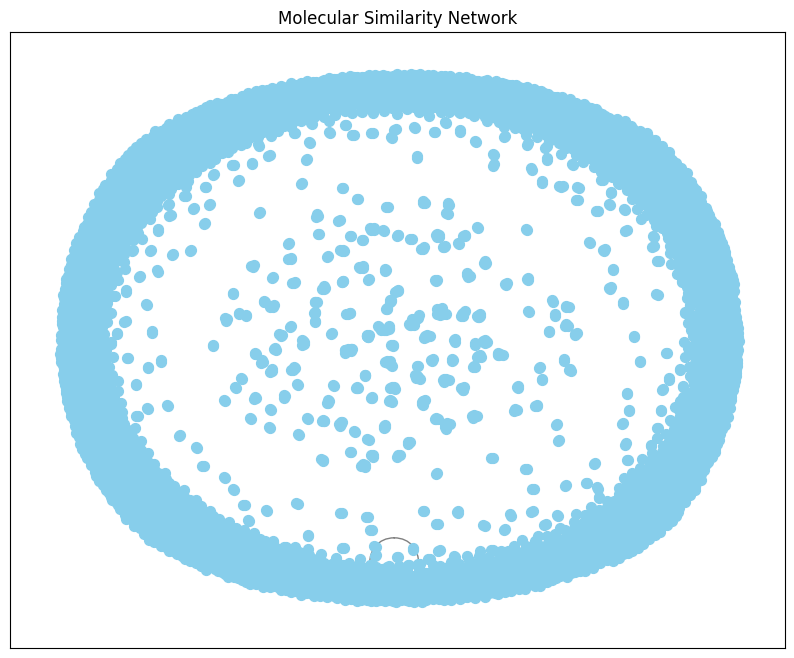

In [45]:
G = build_similarity_network(smiles_list, threshold=0.7)
visualize_similarity_network(G)

## ChembertA

In [12]:
import torch
from transformers import AutoModel, AutoTokenizer

# Load ChemBERTa-2 tokenizer and model
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_chembert = AutoModel.from_pretrained(model_name)
model_chembert.to(device)  # Move model to GPU (if available)


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(600, 384, padding_idx=1)
    (position_embeddings): Embedding(515, 384, padding_idx=1)
    (token_type_embeddings): Embedding(1, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.144, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-2): 3 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.109, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dr

In [13]:
import torch.nn.functional as F

# Load ChemBERTa-2 model & tokenizer
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_chembert = AutoModel.from_pretrained(model_name)

# Use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_chembert.to(device)

# Define batch size (adjust to fit GPU memory)
batch_size = 8  # Lower if still running out of memory

# Store results
results = {}

# Convert SMILES to batches
unique_smiles = list(set(unique_smiles))  # Ensure uniqueness
num_batches = len(unique_smiles) // batch_size + (len(unique_smiles) % batch_size != 0)

# Process in batches to prevent memory overflow
for i in tqdm.tqdm(range(0, len(unique_smiles), batch_size)):
    batch_smiles = unique_smiles[i : i + batch_size]  # Take batch
    inputs = tokenizer(batch_smiles, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model_chembert(**inputs)  # Forward pass

    hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_dim)
    attention_scores = F.softmax(hidden_states.mean(dim=-1), dim=-1)  # Shape: (1, seq_len)

    # Pooling strategy (Choose one)
    pooled_embeddings = hidden_states[:, 0, :]  # CLS token
    #pooled_embedding = hidden_states.mean(dim=1)  # Mean Pooling
    # pooled_embedding = hidden_states.max(dim=1)[0]  # Max Pooling
    # pooled_embedding = torch.einsum("bs,bsd->bd", attention_scores, hidden_states)  # Attention Pooling
    # pooled_embedding = hidden_states[:, -1, :]  # Last Token
    # Move to CPU to avoid memory overload
    pooled_embeddings = pooled_embeddings.cpu().numpy()

    # Store in results dictionary
    for j, smile in enumerate(batch_smiles):
        results[smile] = pooled_embeddings[j]

    # Free up GPU memory
    del inputs, outputs, hidden_states, pooled_embeddings
    torch.cuda.empty_cache()

print(f"Processed {len(results)} SMILES successfully!")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 657/657 [00:07<00:00, 88.06it/s]

Processed 5254 SMILES successfully!


In [14]:
smiles = list(results.keys())
embeddings = np.array(list(results.values()))
feature_df_chembert = pd.DataFrame(embeddings, index=smiles)

# Reset the index and make 'smiles' a column
feature_df_chembert.reset_index(inplace=True)
feature_df_chembert.rename(columns={'index': 'SMILES'}, inplace=True)

# Rename the feature columns
feature_df_chembert.columns = ['SMILES'] + [f"Feature {i+1}" for i in range(feature_df_chembert.shape[1] - 1)]

# Display the resulting DataFrame
feature_df_chembert.head()
feature_df_chembert = pd.merge(feature_df_chembert, specs_smiles_plp, on='SMILES', how='left')
high_cols = [col for col in specs_smiles_plp.columns if "High" in col or "nontoxic" in col]
nont_tox_cols = [col for col in specs_smiles_plp.columns if "nontoxic" in col]
low_cols = [col for col in specs_smiles_plp.columns if "Low" in col]

# Create the label column based on conditions
feature_df_chembert["label"] = "no_plp"  # Default
feature_df_chembert["label_refined"] = "no_plp" # Default


# If any High columns are 1, set label to 1
feature_df_chembert.loc[feature_df_chembert[high_cols].sum(axis=1) > 0, "label"] = "high_tox_plp"

feature_df_chembert.loc[feature_df_chembert[["High_PLP_10uM_>80"]].sum(axis=1) > 0, "label_refined"] = "high_tox_plp"
feature_df_chembert.loc[feature_df_chembert[["nontoxic_10uM_>80"]].sum(axis=1) > 0, "label_refined"] = "non_tox_plp"

# If any Low columns are 1, set label to 1
feature_df_chembert.loc[feature_df_chembert[low_cols].sum(axis=1) > 0, "label"] = "low_plp"

feature_df_chembert.loc[feature_df_chembert[low_cols].sum(axis=1) > 0, "label_refined"] = "low_plp"

/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


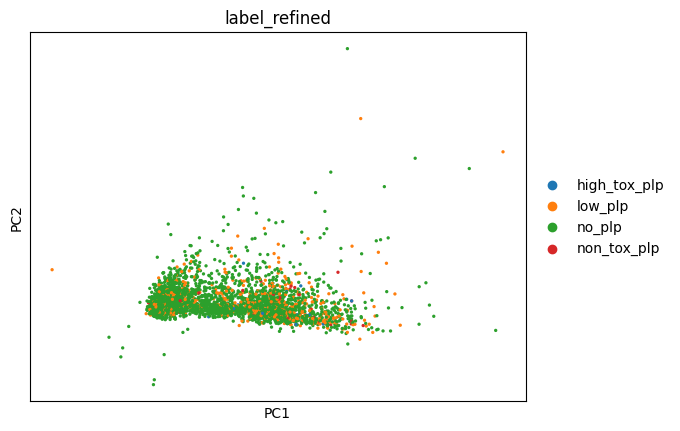

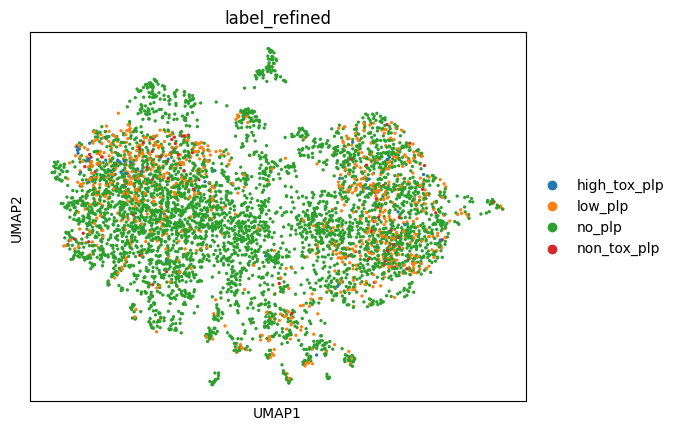

In [15]:
features = [feat for feat in feature_df_chembert.columns if "Feature" in feat]
meta_feats = [feat for feat in feature_df_chembert.columns if feat not in features]
adata = ad.AnnData(X = feature_df_chembert[features],obs=feature_df_chembert[meta_feats])

sc.tl.pca(adata, n_comps=150)
sc.pl.pca(adata, color='label_refined',legend_loc="right margin")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='label_refined',legend_loc="right margin")

In [ ]:
adata.obs["SMILES"] = adata.obs["SMILES"].astype(str)
properties_list = adata.obs["SMILES"].apply(compute_molecular_properties)

# Convert list of dictionaries to DataFrame
properties_df = pd.DataFrame(properties_list.tolist(), index=adata.obs.index)

# Fill NaNs if any molecules failed
properties_df = properties_df.fillna(np.nan)

# Merge into adata.obs
adata.obs = pd.concat([adata.obs, properties_df], axis=1)

# Save updated AnnData
adata.write_h5ad("your_updated_file.h5ad")

print("Added molecular properties to AnnData object!")

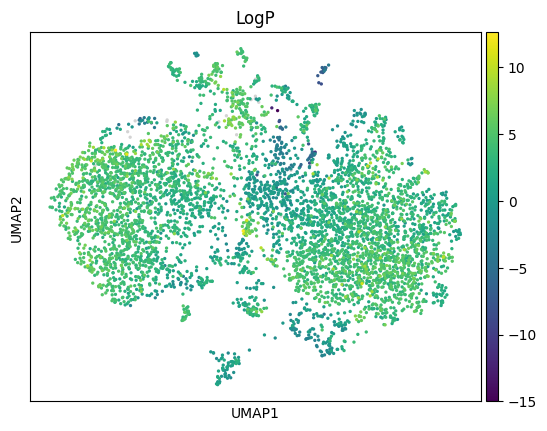

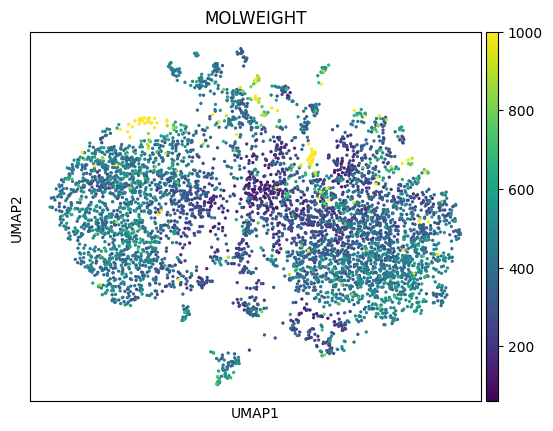

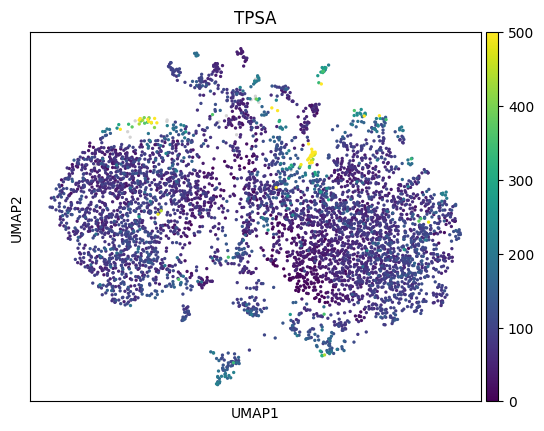

In [37]:
#sc.pl.umap(adata, color='%Induction',legend_loc="right margin")
sc.pl.umap(adata, color='LogP',legend_loc="right margin", vmin = -15)
sc.pl.umap(adata, color='MOLWEIGHT',legend_loc="right margin", vmax=1000)
sc.pl.umap(adata, color='TPSA',legend_loc="right margin", vmax=500)

In [21]:
df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
df['SMILES'] = adata.obs['SMILES'].values


In [23]:
df.to_csv("chemberta_specs5k_features.csv")

## Classification

In [16]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Function for stratified splitting with no batch overlap
def stratified_split_no_batch_overlap(
    adata, 
    label_col="label", 
    batch_col="batch_id", 
    test_size=0.2, 
    val_size=0.1, 
    random_seed=42, 
    obsm_key=None
):
    np.random.seed(random_seed)

    obs_df = adata.obs.copy()

    # Use specified `obsm` key if provided, otherwise use `X`
    if obsm_key is not None:
        if obsm_key not in adata.obsm.keys():
            raise ValueError(f"obsm_key '{obsm_key}' not found in AnnData.obsm. Available keys: {list(adata.obsm.keys())}")
        feature_matrix = adata.obsm[obsm_key]
        feature_names = ["Feature_" + str(col) for col in range(feature_matrix.shape[1])]
    else:
        feature_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        feature_names = ["Feature_" + str(col) for col in adata.var.index]

    feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=adata.obs.index)
    df = pd.concat([obs_df, feature_df], axis=1)

    if batch_col not in df.columns:
        raise ValueError(f"Batch column '{batch_col}' not found in AnnData object.")
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in AnnData object.")

    batch_label_groups = df[[batch_col, label_col]].drop_duplicates()

    train_groups, test_groups = train_test_split(
        batch_label_groups, stratify=batch_label_groups[label_col], test_size=test_size, random_state=random_seed
    )

    val_groups, train_groups = train_test_split(
        train_groups, stratify=train_groups[label_col], test_size=1 - (val_size / (1 - test_size)), random_state=random_seed
    )

    train_df = df[df[batch_col].isin(train_groups[batch_col])].reset_index(drop=True)
    val_df = df[df[batch_col].isin(val_groups[batch_col])].reset_index(drop=True)
    test_df = df[df[batch_col].isin(test_groups[batch_col])].reset_index(drop=True)

    return train_df, val_df, test_df

# Training and Evaluation
def evaluate_models(adata, obsm_keys=["X", "X_pca", "X_pca_harmony"], label_col="label", batch_col="batch_id", undersample=False):
    results = []
    predictions = []

    for split_seed in range(5):  # 5 random splits
        for obsm_key in obsm_keys:
            print(f"Evaluating for split seed {split_seed} and features {obsm_key}")

            # Perform stratified split
            train, val, test = stratified_split_no_batch_overlap(
                adata, label_col=label_col, batch_col=batch_col, random_seed=split_seed, obsm_key=obsm_key
            )

            # Combine train and validation sets
            train = pd.concat([train, val], axis=0)

            # Extract features and labels
            train_X = train[[feat for feat in train.columns if "Feature" in feat]]
            train_y = train[label_col]

            test_X = test[[feat for feat in test.columns if "Feature" in feat]]
            test_y = test[label_col]

            # Label encoding
            label_encoder = LabelEncoder()
            train_y_encoded = label_encoder.fit_transform(train_y)
            test_y_encoded = label_encoder.transform(test_y)

            # Optional undersampling
            if undersample:
                class_counts = np.bincount(train_y_encoded)
                min_class_size = max(3 * np.min(class_counts), np.min(class_counts) * 2)
                
                train_balanced_indices = np.hstack([
                    np.random.choice(np.where(train_y_encoded == cls)[0], min(min_class_size, count), replace=False)
                    for cls, count in enumerate(class_counts)
                ])
                
                train_X = train_X.iloc[train_balanced_indices]
                train_y_encoded = train_y_encoded[train_balanced_indices]

            # Define models
            models = {
                'RandomForest': RandomForestClassifier(random_state=42),
                'XGBoost': XGBClassifier(random_state=42),
                'TabPFN': TabPFNClassifier(ignore_pretraining_limits=True, random_state=42),
            }

            # Train and evaluate
            for name, model in models.items():
                print(f"Training {name} on {obsm_key}")

                model.fit(train_X, train_y_encoded)

                test_preds = model.predict(test_X)
                test_probs = (
                    model.predict_proba(test_X)[:, 1] if hasattr(model, "predict_proba") and len(label_encoder.classes_) == 2 else None
                )

                test_roc = (
                    roc_auc_score(test_y_encoded, test_probs, multi_class="ovr") if test_probs is not None else None
                )
                test_f1 = f1_score(test_y_encoded, test_preds, average='weighted')
                test_precision = precision_score(test_y_encoded, test_preds, average='weighted')
                test_recall = recall_score(test_y_encoded, test_preds, average='weighted')

                results.append({
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed,
                    "ROC AUC": test_roc,
                    "Precision": test_precision,
                    "Recall": test_recall,
                    "F1 Score": test_f1,
                })

                # Store predictions
                preds_df = pd.DataFrame({
                    "True Label": test_y,
                    "Predicted Label": label_encoder.inverse_transform(test_preds),
                    "Model": name,
                    "Features": obsm_key,
                    "Seed": split_seed
                })
                predictions.append(preds_df)

    return pd.DataFrame(results), pd.concat(predictions)
    
# Example usage
results_df, predictions_df = evaluate_models(adata, obsm_keys=["X_pca"], label_col="label", batch_col="Batch_nr", undersample = False)
results_df_under, predictions_df_under = evaluate_models(adata, obsm_keys=["X_pca"], label_col="label", batch_col="Batch_nr", undersample = True)


Evaluating for split seed 0 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 1 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 2 and features X_pca
Training RandomForest on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 3 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 4 and features X_pca
Training RandomForest on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 0 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 1 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 2 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 3 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

Evaluating for split seed 4 and features X_pca
Training RandomForest on X_pca
Training XGBoost on X_pca
Training TabPFN on X_pca


/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovyan/share/data/analyses/PLP/molt5/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

In [17]:
def plot_comparison(results_dfs, filtering_levels):
    """
    Plots model performance across different feature sets and filtering levels.

    Parameters:
        results_dfs (list of pd.DataFrame): List of results DataFrames to compare.
        filtering_levels (list of str): Labels for each filtering level.
    """

    # Ensure proper filtering labels
    if len(results_dfs) == 1:
        results_dfs[0]["Filtering"] = filtering_levels[0]
        combined_df = results_dfs[0]
    else:
        combined_df = pd.concat([
            df.assign(Filtering=filtering_levels[i]) for i, df in enumerate(results_dfs)
        ])

    metrics = ["F1 Score", "Accuracy"]
    titles = ["F1 Score", "Accuracy"]

    # Define feature color map
    feature_palette = {
        "Full Features": "C0",
        "X_pca": "C1",
        "X_pca_harmony": "C2"
    }

    # Create figure with subplots per filtering level
    g = sns.catplot(
        data=combined_df,
        x="Model",
        y="F1 Score",
        hue="Features",
        col="Filtering",  # Separate plots for filtering levels
        kind="bar",
        palette=feature_palette,
        height=5, aspect=1.2,
        dodge=True  # Keep feature sets separate
    )

    g.set_axis_labels("Model", "Weighted F1 Score")
    g.set_titles("{col_name}")  # Use filtering level as title
    g.set(ylim=(combined_df["F1 Score"].min() * 0.98, min(1.0, combined_df["F1 Score"].max() * 1.02)))

    # Move legend outside
    plt.legend(title="Features", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Repeat for Accuracy
    k = sns.catplot(
        data=combined_df,
        x="Model",
        y="Recall",
        hue="Features",
        col="Filtering",
        kind="bar",
        palette=feature_palette,
        height=5, aspect=1.2,
        dodge=True
    )

    k.set_axis_labels("Model", "Recall")
    k.set_titles("{col_name}")
    k.set(ylim=(combined_df["Recall"].min() * 0.98, min(1.0, combined_df["Recall"].max() * 1.02)))

    plt.legend(title="Features", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    t = sns.catplot(
        data=combined_df,
        x="Model",
        y="Precision",
        hue="Features",
        col="Filtering",
        kind="bar",
        palette=feature_palette,
        height=5, aspect=1.2,
        dodge=True
    )

    t.set_axis_labels("Model", "Precision")
    t.set_titles("{col_name}")
    t.set(ylim=(combined_df["Precision"].min() * 0.98, min(1.0, combined_df["Precision"].max() * 1.02)))

    plt.legend(title="Features", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

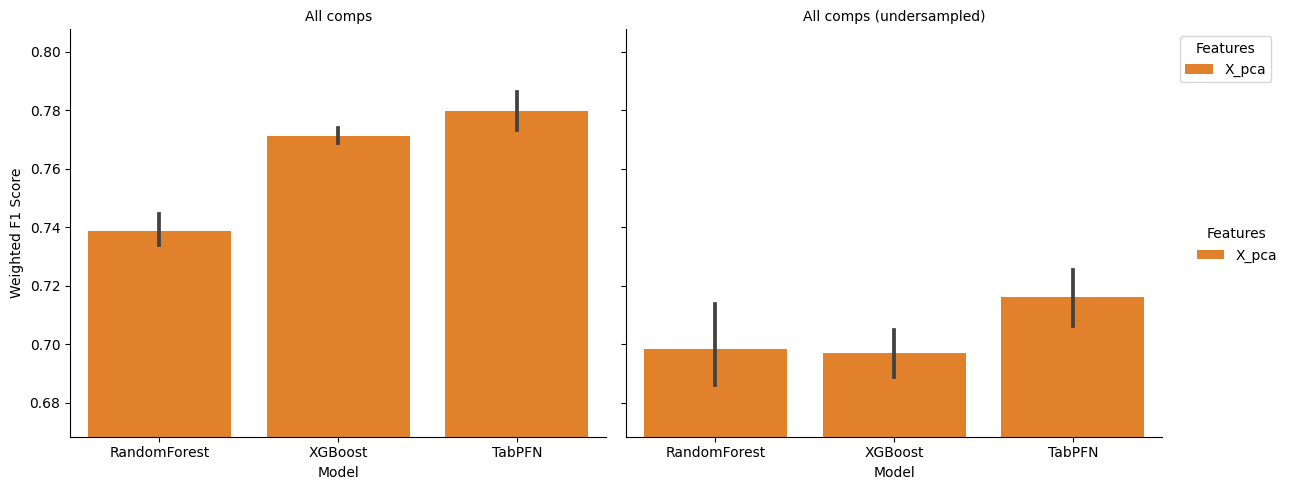

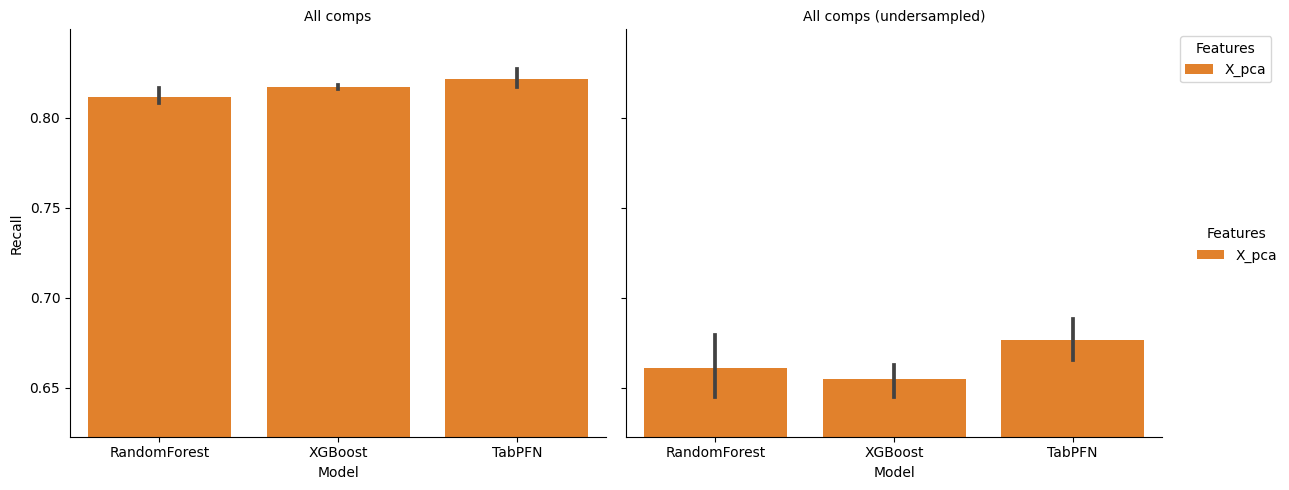

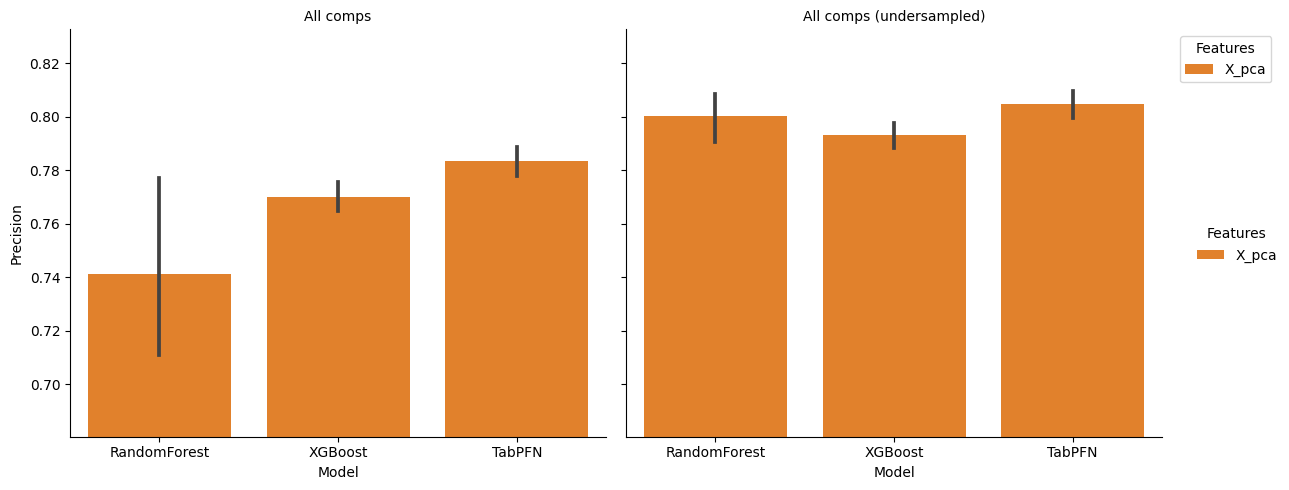

In [18]:
plot_comparison([results_df, results_df_under],  ["All comps", "All comps (undersampled)"])

In [29]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrices(predictions):
    """
    Plots confusion matrices averaged over different seeds and reports values as percentages
    with standard deviation annotated as ± in each cell.
    
    Parameters:
        predictions (pd.DataFrame): A DataFrame containing:
            - 'True Label': Actual labels
            - 'Predicted Label': Predicted labels
            - 'Model': Model name
            - 'Features': Feature type used
            - 'Seed': The random seed used in training
    """

    unique_models = predictions["Model"].unique()
    unique_features = predictions["Features"].unique()
    
    for model in unique_models:
        for feature in unique_features:
            subset = predictions[(predictions["Model"] == model) & (predictions["Features"] == feature)]
            if subset.empty:
                continue

            # Get unique labels
            labels = np.unique(np.concatenate([subset["True Label"], subset["Predicted Label"]]))

            # Create confusion matrices for each seed
            seed_matrices = []
            for seed in subset["Seed"].unique():
                seed_subset = subset[subset["Seed"] == seed]
                cm = confusion_matrix(seed_subset["True Label"], seed_subset["Predicted Label"], labels=labels)
                seed_matrices.append(cm)

            # Compute mean and standard deviation confusion matrix across seeds
            mean_cm = np.mean(seed_matrices, axis=0)
            std_cm = np.std(seed_matrices, axis=0)

            # Convert to percentage
            mean_cm_percent = mean_cm / mean_cm.sum(axis=1, keepdims=True) * 100  # Normalize by row sum
            std_cm_percent = std_cm / mean_cm.sum(axis=1, keepdims=True) * 100  # Normalize std by row sum

            # Create formatted annotations with mean ± std
            annotations = np.array([
                [f"{mean_cm_percent[i, j]:.1f}±{std_cm_percent[i, j]:.1f}" for j in range(mean_cm.shape[1])]
                for i in range(mean_cm.shape[0])
            ])

            # Plot confusion matrix with percentages and standard deviation
            plt.figure(figsize=(6, 5))
            ax = sns.heatmap(
                mean_cm_percent, annot=annotations, fmt="", cmap="Blues",
                xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor="gray"
            )

            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix (Mean % ± SD)\n{model} ({feature})")

            plt.show()

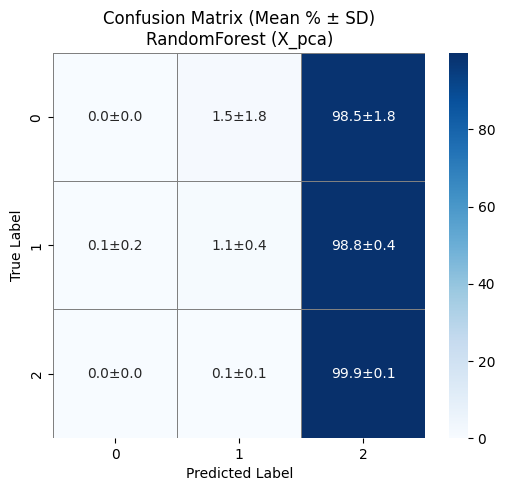

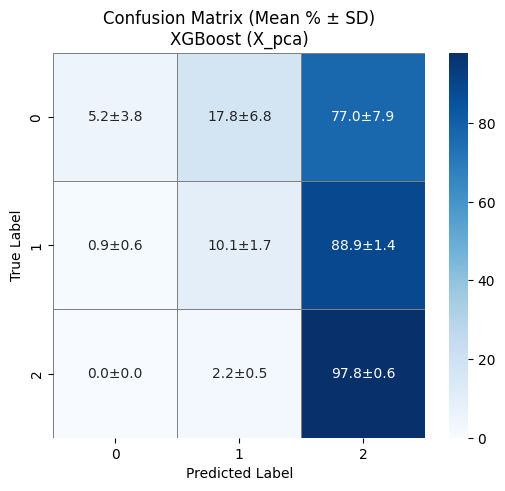

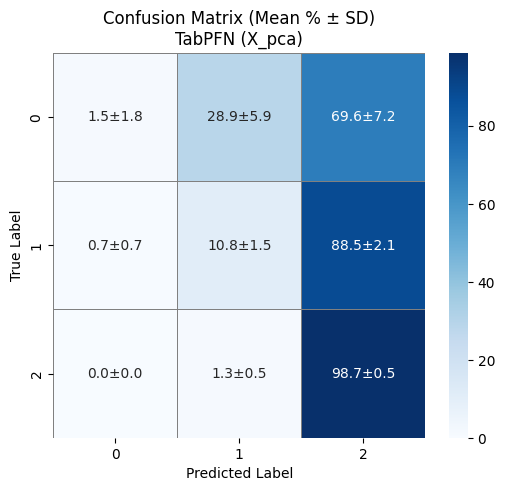

In [30]:
plot_confusion_matrices(predictions_df)
